<a href="https://colab.research.google.com/github/Adrianosh3/NeuronaleNetze/blob/main/CNN_From_Scratch_Version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, utils

import numpy as np
import matplotlib.pyplot as plt

In [45]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.10.0+cu111  Device: cpu


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
# Hyperparameters

num_classes = 2    # Muss y Tensor Dimension entsprechen
Batch_Size = 128
Learning_Rate = 0.001       # Muss individuell angepasst werden
Number_Epochs = 10         # Je höher, desto genauer

In [47]:
####Data augmentation
# Note transforms.ToTensor() scales input images
# to 0-1 range

## train transformations
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

## valid transformations
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [48]:
##########################
### Cats and Dogs Dataset
##########################


training_dataset = datasets.ImageFolder('/content/drive/MyDrive/NN_SS2021/Data gekürzt/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/NN_SS2021/Data gekürzt/val', transform=transform)

#####################################################
### Data Loaders
#####################################################
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=Batch_Size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = Batch_Size, shuffle=False)

In [49]:
### Checking the dataset
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break
for (X_val, y_val) in validation_loader:
    print('X_validation:', X_val.size(), 'type:', X_val.type())
    print('y_validation:', y_val.size(), 'type:', y_val.type())
    break

X_train: torch.Size([128, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([128]) type: torch.LongTensor
X_validation: torch.Size([128, 3, 32, 32]) type: torch.FloatTensor
y_validation: torch.Size([128]) type: torch.LongTensor


In [50]:
print(f'Total number of training examples: {len(training_dataset)}')
print(f'Total number of validation examples: {len(validation_dataset)}')

Total number of training examples: 509
Total number of validation examples: 200


In [51]:
classes = ('cat', 'dog')

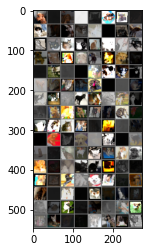

  dog   dog


In [52]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(2)))

In [53]:
class LeNet5(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(LeNet5, self).__init__()
        
       

        self.features = nn.Sequential(
            ##self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 20, kernel_size = 5, stride = 1, padding = 0)
            nn.Conv2d(in_channels, 6, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes),
            nn.Softmax(dim=1)
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        probas = self.classifier(x)
        return probas

In [54]:
model = LeNet5(3, num_classes).to(device)
model

LeNet5(
  (features): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=2, bias=True)
    (5): Softmax(dim=1)
  )
)

In [55]:
# Loss Function vorgeben 
criterion = nn.CrossEntropyLoss()

In [56]:
# Optimizer vorgeben (SGD Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(), lr = Learning_Rate)

In [57]:
## train function 

def train(epoch, train_loss_list,train_accuracy_list, log_interval=200):
    # Set model to training mode
    model.train()
    train_loss,correct = 0,0

    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train) in enumerate(train_loader):

        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward Propagation:  compute predicted outputs by passing inputs to the model
        y_predicted = model(X_train)
        
        # Zero gradient buffers: clear the gradients of all optimized variables
        optimizer.zero_grad() 

        # Calculate loss
        loss = criterion(y_predicted, y_train)

        # Backpropagate: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Update weights: perform a single optimization step (parameter update)
        optimizer.step()

      
        # save loss value in train_loss list
        train_loss += loss.item()  
        
        pred = y_predicted.data.max(1)[1]
        correct += (pred == y_train).float().sum()

        # print training statistics 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X_train), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
      # calculate average loss over an epoch            
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)    
    
    accuracy = 100 * correct / len(train_loader.dataset)
    train_accuracy_list.append(accuracy)
    
    print('Train Epoch: {}\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        loss, correct, len(train_loader.dataset), accuracy))

In [58]:
## Validation function
def validate(val_loss_list,val_accuracy_list):
    model.eval()
    val_loss, correct = 0, 0
    
    for X_val, y_val in validation_loader:

        X_val = X_val.to(device)
        y_val = y_val.to(device)

        # Forward Propagation:  compute predicted outputs by passing inputs to the model
        y_predicted = model(X_val)
        
        # Calculate loss
        loss = criterion(y_predicted, y_val)
        val_loss += loss.item()  
        
        pred = y_predicted.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(y_val.data).cpu().sum()

    val_loss /= len(validation_loader)
    val_loss_list.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    val_accuracy_list.append(accuracy)
    
    print('Val Epoch: {}\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        loss, correct, len(validation_loader.dataset), accuracy))

In [59]:
######This is now the actual execution of the process
## Train model
##%%time

train_loss_values,val_loss_values, train_acc_values, val_acc_values = [], [], [], []
for epoch in range(Number_Epochs):
    train(epoch,train_loss_values, train_acc_values,)
    validate(val_loss_values, val_acc_values)

Train Epoch: 0 [0/509 (0%)]	Loss: 0.692947
Train Epoch: 0
Train set: Average loss: 0.6955, Accuracy: 261.0/509 (51%)

Val Epoch: 0
Validation set: Average loss: 0.6734, Accuracy: 99/200 (50%)

Train Epoch: 1 [0/509 (0%)]	Loss: 0.692518
Train Epoch: 1
Train set: Average loss: 0.6948, Accuracy: 257.0/509 (50%)

Val Epoch: 1
Validation set: Average loss: 0.6735, Accuracy: 99/200 (50%)

Train Epoch: 2 [0/509 (0%)]	Loss: 0.695607
Train Epoch: 2
Train set: Average loss: 0.6910, Accuracy: 258.0/509 (51%)

Val Epoch: 2
Validation set: Average loss: 0.6735, Accuracy: 99/200 (50%)

Train Epoch: 3 [0/509 (0%)]	Loss: 0.692939
Train Epoch: 3
Train set: Average loss: 0.6926, Accuracy: 259.0/509 (51%)

Val Epoch: 3
Validation set: Average loss: 0.6735, Accuracy: 99/200 (50%)

Train Epoch: 4 [0/509 (0%)]	Loss: 0.691885
Train Epoch: 4
Train set: Average loss: 0.6900, Accuracy: 255.0/509 (50%)

Val Epoch: 4
Validation set: Average loss: 0.6735, Accuracy: 99/200 (50%)

Train Epoch: 5 [0/509 (0%)]	Loss: 0

No handles with labels found to put in legend.


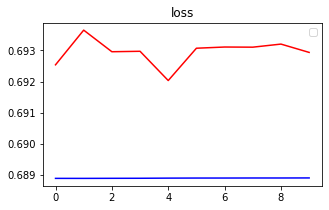

In [60]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(Number_Epochs), train_loss_values, 'r')
plt.plot(np.arange(Number_Epochs), val_loss_values, 'b')
plt.title('loss')
plt.legend()

No handles with labels found to put in legend.


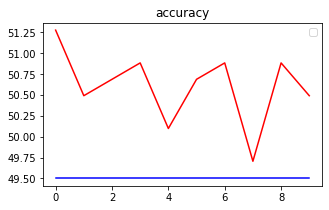

In [61]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(Number_Epochs), train_acc_values, 'r')
plt.plot(np.arange(Number_Epochs),  val_acc_values, 'b')
plt.title('accuracy');
plt.legend()

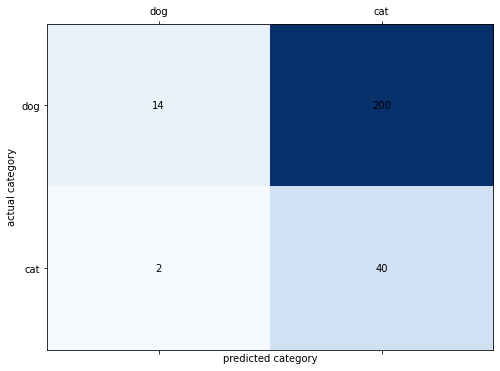

In [63]:
### create a confusion matrix

testloader = validation_loader 

classes = ('dog', 'cat')
#Berechnung der Confusion-Matrix
confusion_matrix = np.zeros([len(classes),len(classes)], int)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        dataiter = iter(testloader)
        images, labels = dataiter.next()
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1
#Erstellung des Plots
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=confusion_matrix.max(), cmap=plt.get_cmap('Blues'))
plt.ylabel('actual category')
plt.yticks(range(2), classes)
plt.xlabel('predicted category')
plt.xticks(range(2), classes)
#Eintragen der Häufigkeiten in die Confusion-Matrix
for (i, j), z in np.ndenumerate(confusion_matrix):
    ax.text(j, i, z, ha='center', va='center')
plt.show()
